In [77]:
import matplotlib.pyplot as plt


import os
import numpy as np
import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam,Adagrad
import pyro.poutine as poutine
from torchvision.utils import save_image

import matplotlib.pylab as plt

from PIL import Image # Module for image rotation (making use of PIL)

from utils.models import HMT


In [78]:
#from utils.MiraBest import MiraBest
from utils.MiraBest_full import MiraBest_full
from utils.FRDEEP import FRDEEPF
from utils.data_downloader import dataloader_first_noisy
from utils.data_downloader import dataloader_first_FRDEEP
from utils.classifier_fr_2 import classification_procedure

import network_configurations.neural_net_conf_0_2_dropout as network #change this here to change configuration

In [79]:
def inception_score():
    model = HMT().cuda()
    model.load_state_dict(torch.load('model.mod'))
    
    return model.eval()

In [80]:
inception_classifier = inception_score()

In [81]:
x = np.load('0_FIRST_IMAGE_NUMPY_x.np.npy')

In [82]:
y = np.load('0_FIRST_IMAGE_NUMPY_y.np.npy')

In [83]:
from numpy import asarray
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import exp

In [84]:
import numpy as np

In [85]:
def calculate_inception_score(p_yx, eps=1E-16):
    # calculate p(y)
    p_y = expand_dims(p_yx.mean(axis=0), 0)

    # kl divergence for each image
    kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))

    # sum over classes
    sum_kl_d = kl_d.sum(axis=1)

    # average over images
    avg_kl_d = mean(sum_kl_d)

    # undo the logs
    is_score = exp(avg_kl_d)
    return is_score

In [86]:
inception_score = []
edge_value = []
for i in range(0,75,1):
    fullsize_image = np.zeros((500,1,150,150))
    edge = i
    for i in range (0,500):
        x_tocrp = x[i,0,:,:]
        fullsize_image[i,0,edge:150-edge,edge:150-edge]=x_tocrp[edge:150-edge,edge:150-edge]
    image_to_test = torch.from_numpy(fullsize_image).float().to("cuda:0")

    valid_pred = inception_classifier(image_to_test)
    m = nn.Softmax(dim=1)
    values=m(valid_pred).cpu().detach().numpy()
    score = calculate_inception_score(values)
    inception_score.append(score)
    edge_value.append(edge)

In [87]:
import numpy as np

In [132]:
interval = [0]
num_of_contours = 12
initial = 0.001
for n in range (0,num_of_contours):
    interval.append(initial)
    initial = initial+0.001

In [133]:
interval

[0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.010000000000000002,
 0.011000000000000003,
 0.012000000000000004]

In [134]:
x_data_no_noise = torch.from_numpy(x).float().to("cuda:0")
valid_pred = inception_classifier(x_data_no_noise.cuda())
m = nn.Softmax(dim=1)
values=m(valid_pred).cpu().detach().numpy()
score = calculate_inception_score(values)

In [135]:
score

1.4025596

In [136]:
x = np.load('0_FIRST_IMAGE_NUMPY_x.np.npy')
inception_score_noise = []
noise_value = []
for alpha in interval:
    noise=np.random.random((500,1,150,150))*alpha
    
    array_noise = torch.from_numpy(noise).float().to("cuda:0")
    x_data_no_noise = torch.from_numpy(x).float().to("cuda:0")
    
    x_data=x_data_no_noise+array_noise
    valid_pred = inception_classifier(x_data.cuda())
    m = nn.Softmax(dim=1)
    values=m(valid_pred).cpu().detach().numpy()
    score = calculate_inception_score(values)
    noise_value.append(alpha)
    inception_score_noise.append(score)

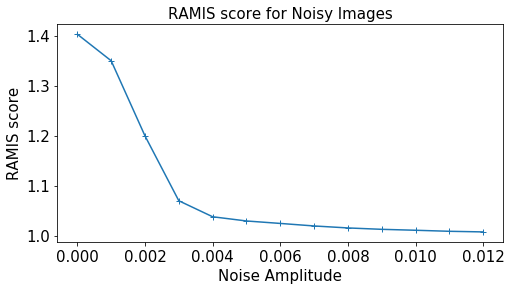

In [143]:
plt.figure(figsize=(8,4))
plt.plot(noise_value,inception_score_noise,'+-')
plt.ylabel('RAMIS score',fontsize=15)
plt.xlabel('Noise Amplitude',fontsize=15)
plt.title('RAMIS score for Noisy Images',fontsize=15)
plt.tick_params(labelsize=15)


([<matplotlib.axis.XTick at 0x7f3e4b0ab208>,
 <a list of 11 Text xticklabel objects>)

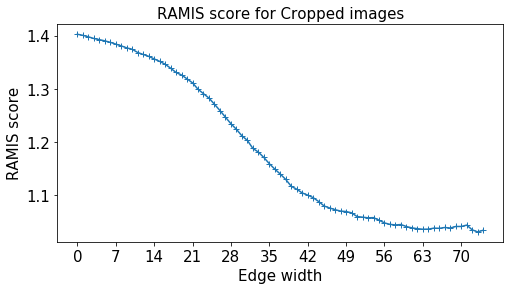

In [144]:
plt.figure(figsize=(8,4))
plt.plot(edge_value,inception_score,'+-')
plt.ylabel('RAMIS score',fontsize=15)
plt.xlabel('Edge width',fontsize=15)
plt.title('RAMIS score for Cropped images',fontsize=15)
plt.tick_params(labelsize=15)
plt.xticks(np.arange(0,75,7))

In [145]:
import cv2

In [148]:
inception_score_blur = []
blur_value = []
for j in range(1,75,2):
    fullsize_image = np.zeros((500,1,150,150))
    for i in range (0,500):
        x_toblur = x[i,0,:,:]
        fullsize_image[i,0]=cv2.GaussianBlur(x_toblur, (j, j), 0)
    image_to_test = torch.from_numpy(fullsize_image).float().to("cuda:0")

    valid_pred = inception_classifier(image_to_test)
    m = nn.Softmax(dim=1)
    values=m(valid_pred).cpu().detach().numpy()
    temp=values[:,0]
    score = calculate_inception_score(values)
    inception_score_blur.append(score)
    blur_value.append(j)

([<matplotlib.axis.XTick at 0x7f3e4af724a8>,
 <a list of 10 Text xticklabel objects>)

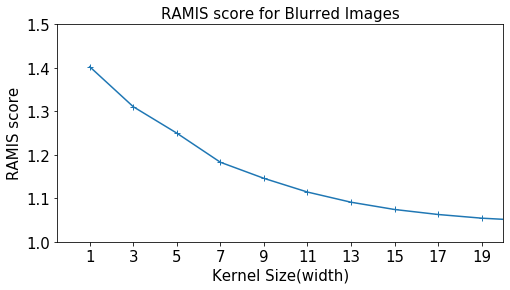

In [149]:
plt.figure(figsize=(8,4))
plt.plot(blur_value,inception_score_blur,'+-')
plt.ylim(1.0,1.5)
plt.xlim(-0.5,20)
plt.ylabel('RAMIS score',fontsize=15)
plt.xlabel('Kernel Size(width)',fontsize=15)
plt.title('RAMIS score for Blurred Images',fontsize=15)
plt.tick_params(labelsize=15)
plt.xticks(np.arange(1,20,2))

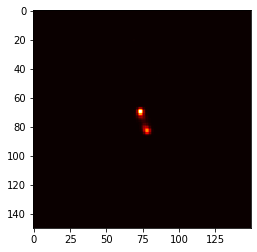

In [252]:
plt.imshow(x[0][202][0].cpu().detach().numpy(),cmap='hot')

In [52]:
image_toblur = x[202][0]

In [53]:
radio_blur = cv2.GaussianBlur(image_toblur, (75,75), 0)

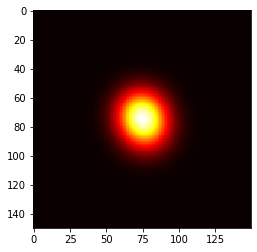

In [54]:
plt.imshow(radio_blur,cmap='hot')

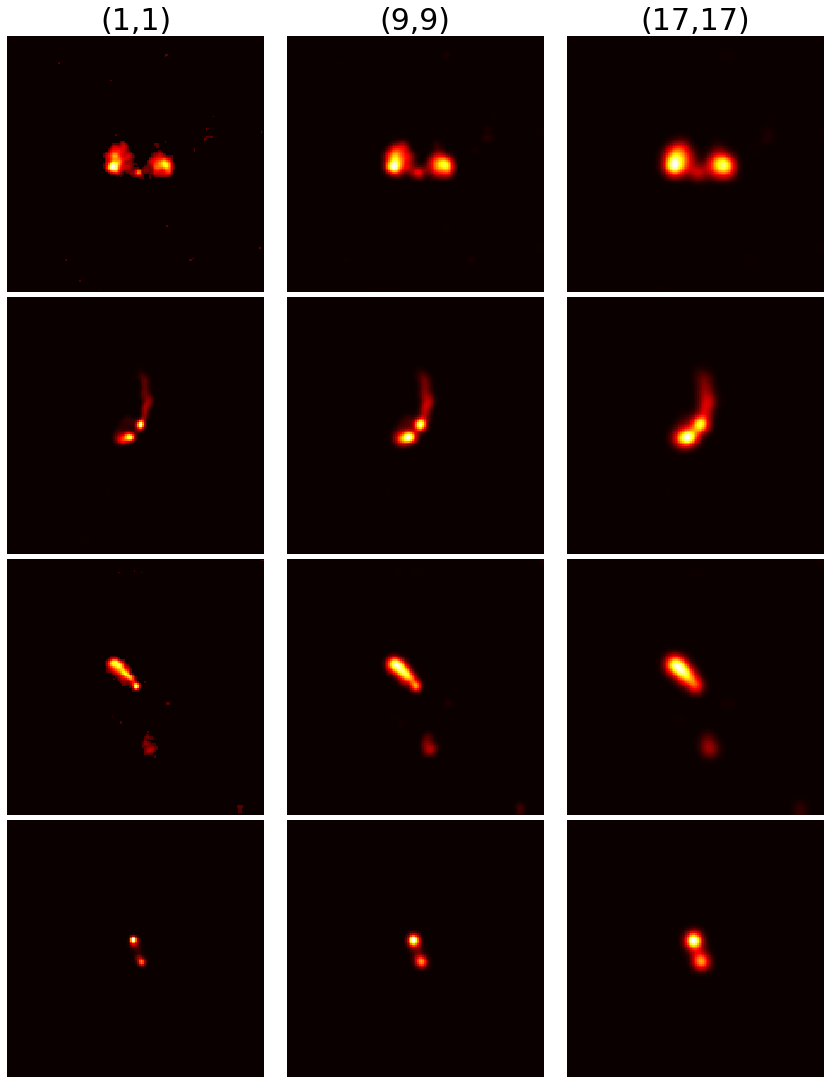

In [174]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(15-3,20-5))



plots = []
images = [400,403,302,202]
bluring_kernel = [1,9,17]
noise_level = [0,0.002,0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.010000000000000002]

x = np.load('0_FIRST_IMAGE_NUMPY_x.np.npy')




for i in range(4):
    image_toblur = x[images[i]][0]
    for j in range(3):
            
            radio_blur = cv2.GaussianBlur(image_toblur, (bluring_kernel[j],bluring_kernel[j]), 0)
            ax = plt.subplot2grid((4,3), (i,j))
            ax.imshow(radio_blur,cmap='hot')
            ax.set_axis_off()
            
            if i == 0:
                ax.set_title('('+str(bluring_kernel[j])+','+str(bluring_kernel[j])+')',fontsize= 30)

plt.tight_layout(pad = 0.5)
plt.show()


<Figure size 432x288 with 0 Axes>

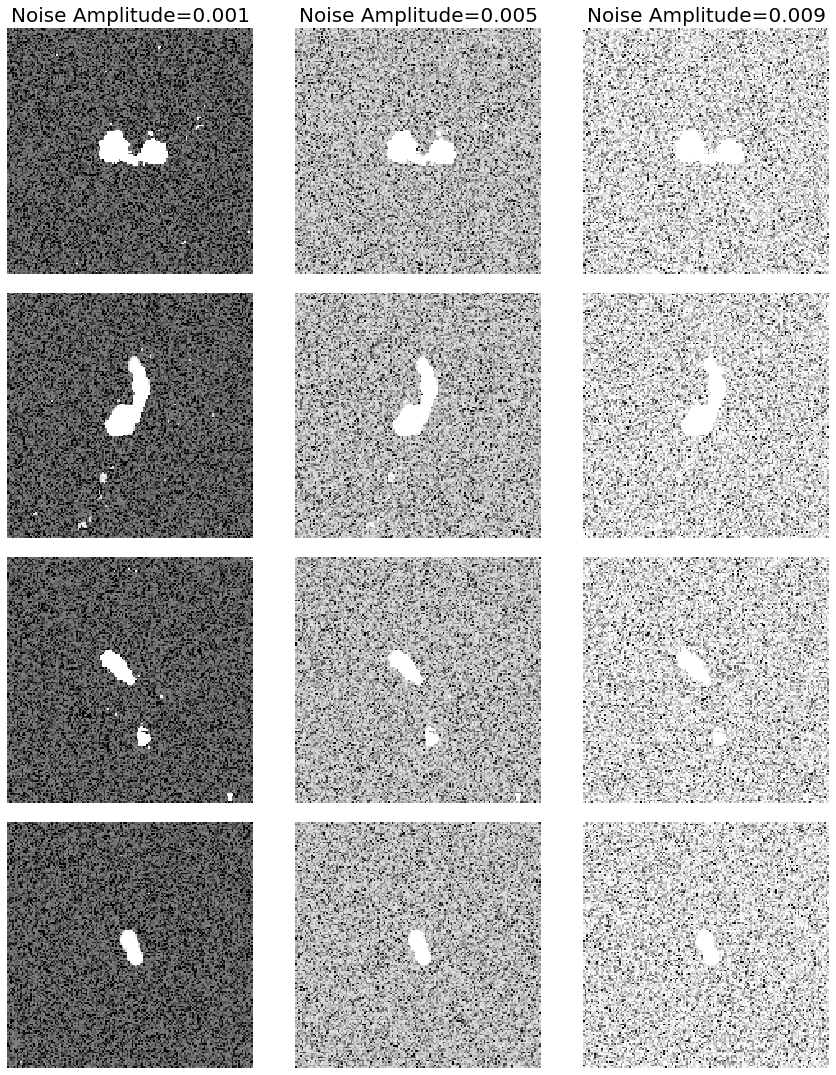

In [164]:
import matplotlib.pyplot as plt
import numpy as np


x = np.load('0_FIRST_IMAGE_NUMPY_x.np.npy')

plt.figure(0)
plt.figure(figsize=(15-3,20-5))
plots = []
images = [400,403,302,202]
bluring_kernel = [1,5,9,13,17]

noise_level = [0.001,0.005, 0.009]




for i in range(4):
    image_tonoise = x[images[i]][0]
    for j in range(3):
            noise=np.random.random((150,150))*noise_level[j]
            radio_blur = image_tonoise + noise
            ax = plt.subplot2grid((4,3), (i,j))
            ax.imshow(np.log(radio_blur),cmap='gray',vmin=log(0.0001), vmax=log(0.008))
            ax.set_axis_off()
            
            if i == 0:
                    ax.set_title('Noise Amplitude='+str(noise_level[j]),fontsize= 20)

plt.tight_layout(pad = 0.01)
plt.show()

<Figure size 432x288 with 0 Axes>

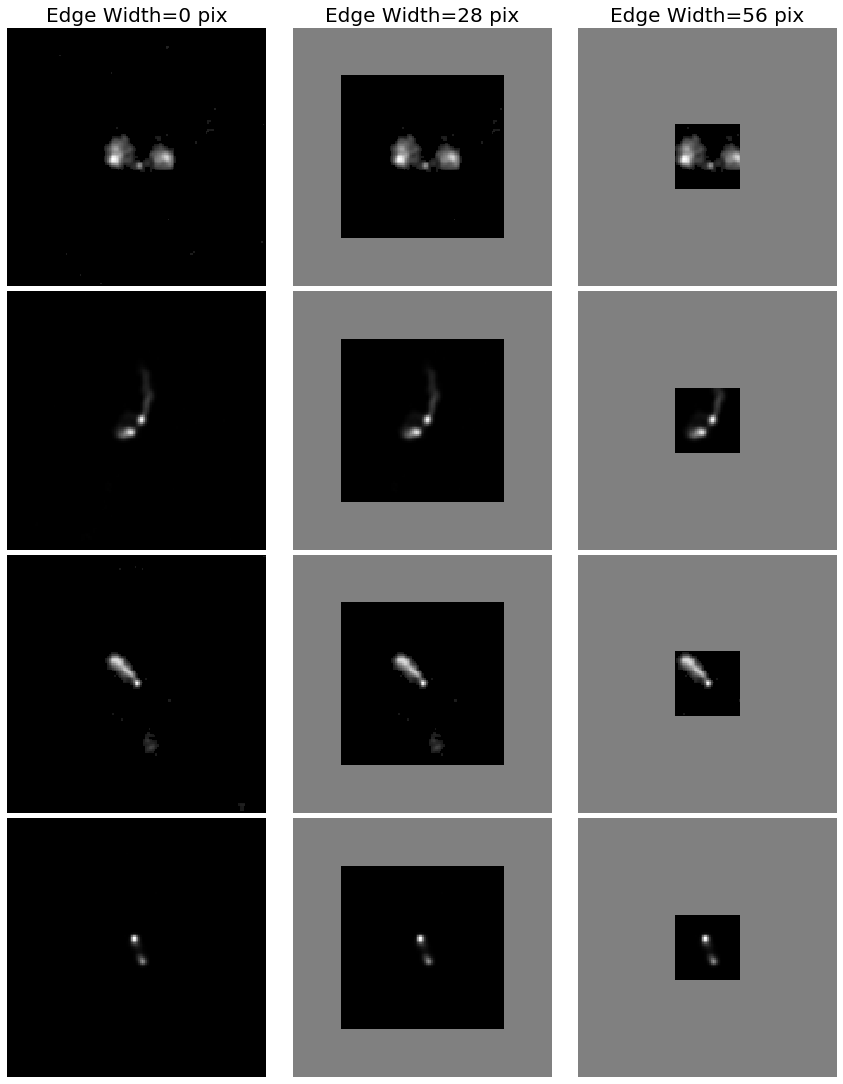

In [168]:
import matplotlib.pyplot as plt
import numpy as np

x = np.load('0_FIRST_IMAGE_NUMPY_x.np.npy')


plt.figure(0)
plt.figure(figsize=(15-3,20-5))
plots = []
images = [400,403,302,202]
bluring_kernel = [1,9,17]
l_list = [0,28,56]


for i in range(4):
    image_toblur = x[images[i]][0]
    for j in range(3):
            l = l_list[j]
            radio_blur = image_toblur
            radio_blur[0:l,0:150] = 0.5
            radio_blur[150-l:150,0:150] = 0.5
            radio_blur[l:150-l,0:l] = 0.5
            radio_blur[l:150-l,150-l:150] = 0.5
            ax = plt.subplot2grid((4,3), (i,j))
            ax.imshow(radio_blur,cmap='gray')
            ax.set_axis_off()
            
            if i == 0:
                ax.set_title('Edge Width='+str(l)+' pix',fontsize= 20)

plt.tight_layout(pad = 0.5)
plt.show()

In [371]:
image_toblur = x[0][images[i]][0].cpu().detach().numpy()

TypeError: 'int' object is not subscriptable

Predictions as distort image:[[0.7976411  0.20235895]]
Predictions as undistort image:[[0.8856829  0.11431717]]
----------------


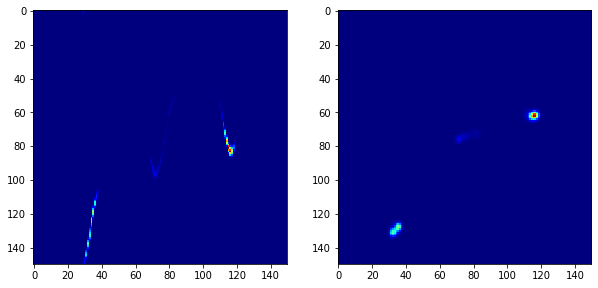

In [39]:

j = 16
x = np.load('0_FIRST_IMAGE_NUMPY_x.np.npy')
img = x[j][0]
plt.figure(figsize=(10,20))
A = img.shape[0] /7.0
w = 1.5 / img.shape[1]

shift = lambda x: A * np.sin(9.0*np.pi*x * w)
 
for i in range(img.shape[0]):
    img[:,i] = np.roll(img[:,i], int(shift(i)))
    
x_torch = torch.from_numpy(img).float().to("cpu")

valid_pred = inception_classifier(x_torch.reshape(1,1,150,150).cuda())
m = nn.Softmax(dim=1)
values=m(valid_pred).cpu().detach().numpy()
print("Predictions as distort image:"+str(values))
ax = plt.subplot2grid((1,2), (0,0))
ax.imshow(img,cmap='jet')
x = np.load('0_FIRST_IMAGE_NUMPY_x.np.npy')
x_torch = torch.from_numpy(x[j][0]).float().to("cpu")
valid_pred = inception_classifier(x_torch.reshape(1,1,150,150).cuda())
m = nn.Softmax(dim=1)
values=m(valid_pred).cpu().detach().numpy()
ax = plt.subplot2grid((1,2), (0,1))
ax.imshow(x_torch,cmap='jet')
print("Predictions as undistort image:"+str(values))
print('----------------')



